# MSM analysis of Chatinkha Res using PyMC3

This details the progress I have made so far in coding an MSM in PyMC3. 

This will be the format:

- Summary of my understanding of the model framework
- What I have done so far
- How this compares to results from MSM
- Questions
- Next steps


## Summary of the model as it stands

We model a markov process in continuous time in which a neonate can be in state $S(t)$ at time $t$. The construction of the model is similar to that used in the MSM package and Lewis (in press). For the purposes of our model each neonate can be in one of two states, either uncolonised $(u)$ or colonised $(c)$.

$$U \overset{\lambda}{\rightarrow} C$$

We model neonates from birth and assume that at birth $(t = 0)$ a neonate is uncolonised $(S(t) = u)$. Neonates are followed up until discharge or day 7 of admission, with up to 3 rectal samples taken on day 0, day 3 and day 7. Once a neonate becomes colonised we no longer include their data in the model, as on the timescales of our study they are unlikely to become uncolonised. As such the only transition that is allowed is from $u$ to $c$ (illustrated above). We are interested in estimating the probability of this transition, $\lambda$, as well as the probability and predictors of the transition. This is similar to a standard survival model, except for the assumption that the exact time of colonisation is known as our data is panel data with arbitrary observation times.

**Some of this bit will probably need to be removed, we are not interested in matrix exponentiation any more**

The timing of the movement from state $u$ to state $c$ is governed by the transition intensity $(q)$. This can be affected by covariates, including time-dependent covariates. The transition intensity represents the instantaneous risk of moving from state $u$ to state $c$:

$$q_{u,c}(t) = \lim_{\delta t \to 0} (P(C(t + \delta t) = c|C(t) = u)/\delta t$$

To fit this model, first a transition matrix, $Q$ is created, in which the rows sum to zero. As we do not model neonates once they have become colonised, transition intensities from 2 are set to 0. A single period of occupancy in state $u$ has an exponential distribution with rate given by $-q_{uu}$

$$Q = \begin{pmatrix} q_{uu} &  q_{uc}\\ q_{cu} & q_{cc} \end{pmatrix} $$

The likelihood for the model is calculated from the transition probability matrix $P(t)$. For a time-homogeneous process, the $(u, c)$ entry of $P(t), p_{u,c}(t),$ is the probability of being in state $c$ at a time $m + n$ in the future, given the state at time $m$ is $c$, though the time of transition from $u$ to $c$ could have been at any time in the period from $m$ to $n$. $P(t)$ is calculated by taking the matrix exponential of the scaled transition intensity matrix using the Pade approximation.

$$P(t) = Exp(tQ)$$

Given an individual $i$ starts out uncolonised at time $t$, then the probability they will have been infected by time $t=T$ is

$$Pr(i \in C{T} | i \in {U}(t)) = p_{uc}(1 - p_{uc})^{T-t-1}$$

Conversely, if $i$ is *not* colonised by time $t=T$ then

$$Pr(i \in U{T} | i \in {U}(t)) = (1 - p_{uc})^{T-t}$$

The likelihood is then the product of terms over $i$ for each colonisation or survival event:

$$L(Y | p) = \prod_{i=1}{n} p_{uc}^{1(U {\rightarrow} C_i)}(1 - p_{uc})^{t_i}$$

**Need to add section on estimation of covariates**


## What I have done so far

This is the updated model, edited by Chris, which includes an updated likelihood function which works effectively. We have abandoned the Q matrix as it is unecessary. 


In [1]:
#Importing the libraries
import pandas as pd
import numpy as np
import scipy as sp
import pymc3 as pm
import matplotlib.pyplot as plt
from theano import *
import theano.tensor as tt
import theano.tensor.slinalg as ttl
#theano.config.compute_test_value = 'raise'
#theano.config.compute_test_value = 'off'

#loading the data
msm_kleb = pd.read_csv(r"msm_data_simple.csv")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Next we will create the function that calculates the log likelihood of the data given a specific probability. This is based on the likelihood equation above.

In [3]:
#this function generates the log likelihood for the data when it is given a probability of transition
def trans_likelihood(state1, state2, tstart, tstop, p):
    #preparing the variables
    #probability of not being colonised is 1 - probability of being colonised
    notp = 1 - p  # Pr(survive a timestep)
    #vector with a 1 when babies are colonised but a zero when they are not
    is_colonised = tt.where(state2 == 2, 1.0, 0.0)
    #this determines the length of time for which babies are not colonised
    num_steps_survives = tstop - tstart - is_colonised
    #log likelihood for one baby
    log_lik = num_steps_survives * tt.log(notp) + is_colonised * tt.log(p)
    #defining the likelihood for all babies
    totL = tt.sum(log_lik)
    return totL

Next we will run the model itself. With the updated likelihood function it works well

C:\Users\ohape\AppData\Local\Temp/ipykernel_21024/2230616736.py:23: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  samples = pm.sample(3000, tune=1000,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 59 seconds.
C:\Users\ohape\AppData\Local\Temp/ipykernel_21024/2230616736.py:37: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(samples)


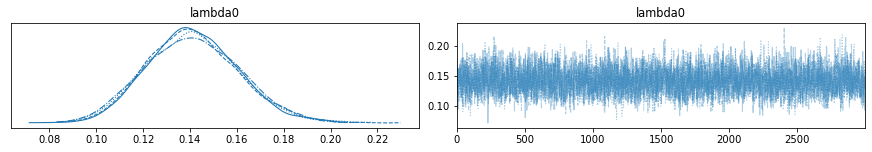

In [4]:
#this is the model itself
if __name__ ==  '__main__':
    def run_mcmc(state1, state2, tstart, tstop):
        with pm.Model() as model:
    
            #setting priors
            #creating the baseline transition rate prior, this will later be 
            #composed of a baseline transition rate and coefficients of all of the covariates
            lambda0 = pm.Beta('lambda0', 1, 1)
            #prior for alpha
            alpha0 = pm.Normal('alpha0', mu=0, sd=1000)
            #priors for betas
            beta1 = pm.Normal('mat_cont', mu=0, sd=1000)
            beta2 = pm.Normal('matabxall', mu=0, sd=1000)
            beta3 = pm.Normal('preterm', mu=0, sd=1000)
            beta4 = pm.Normal('intabx', mu=0, sd=1000)
            beta5 = pm.Normal('abx', mu=0, sd=1000)
            beta6 = pm.Normal('outborn', mu=0, sd=1000)
            beta7 = pm.Normal('sex', mu=0, sd=1000)
            beta8 = pm.Normal('dlivmod', mu=0, sd=1000)
            beta9 = pm.Normal('mathiv', mu=0, sd=1000)
            beta10 = pm.Normal('lbw', mu=0, sd=1000)
            beta11 = pm.Normal('o2', mu=0, sd=1000)
            beta12 = pm.Normal('notbreast', mu=0, sd=1000)
            beta13 = pm.Normal('cot_cont', mu=0, sd=1000)
            beta14 = pm.Normal('mat_hand', mu=0, sd=1000)
            beta15 = pm.Normal('onward', mu=0, sd=1000)
            #beta0 = pm.Normal('beta0', mu = 0, sigma = 1000, shape = 10)
            #later will need to construct the lambda from the alpha and betas            
            

    
            #now using pm.Potential to use the custom log-likelihood function to calculate lambda0
            llh = pm.Potential('llh', trans_likelihood(state1 = state1, 
                                                       state2 = state2, 
                                                       tstart = tstart, 
                                                       tstop = tstop, 
                                                       p = lambda0))
        
            samples = pm.sample(3000, tune=1000, 
                                start={'lambda0': 0.1},
                                target_accept = 0.9
                                )
        
            return samples, model
  #running the model
    samples, model = run_mcmc(state1 = msm_kleb['init_state'].to_numpy(), 
                              state2 = msm_kleb['end_state'].to_numpy(), 
                              tstart = msm_kleb['tstart'].to_numpy(), 
                              tstop = msm_kleb['tstop'].to_numpy()
                              )
#plotting traceplots
    with model:
        pm.traceplot(samples)

As you can see, the estimate for $\lambda$ is 0.14 with the improved likelihood function. This is close to the expected result of 0.16 from MSM. The small difference may be due to the fact that we use a discrete time model whereas MSM uses a continuous time model. There are also differences in how our likelihood is calculated.

However, when trying to use it within the context of the model, I can't seem to get it to work. I keep getting an error which I think is related to having the wrong input type to the Theano argument. I can't figure out how to fix this at the moment. What do you recommend? 

## Questions

- could the problem with the uncertainty related to the maternal colonisation be as simple as treating each day of maternal colonisation as missing data - although this would not allow for us to dictate for example that mothers that become colonised do not become uncolonised. 


## Next steps

